## Import necessary packages

In [680]:
import pandas as pd
import glob, os
import xlrd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import Point
import numpy as np
import geopandas
import shapefile
import netCDF4
import h5py
import datetime as dt
import pyproj
from mpl_toolkits.basemap import Basemap

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

## Visualize sea ice concentration data

In [204]:
# Functions to read AMSR data (Sea ice concentration)
from scipy.stats import kurtosis, skew

def get_AMSR(fileT):

    f1 = h5py.File(fileT, 'r')
    # Latitude & longitude
    lat = f1['HDFEOS/GRIDS/NpPolarGrid25km/lat'][:]
    lon = f1['HDFEOS/GRIDS/NpPolarGrid25km/lon'][:]
    # Sea ice concentration (sic)
    sic = f1['HDFEOS/GRIDS/NpPolarGrid25km/Data Fields/SI_25km_NH_ICECON_DAY'][:]
    
    del f1
    
    return sic, lat, lon

def get_statistics(z, r = 5):
    h,w = np.shape(z)
    z_mean = np.zeros((h, w))
    z_var = np.zeros((h, w))
    z_skew = np.zeros((h, w))
    z_kurt = np.zeros((h, w))
    
    for i in range(0, h):
        for j in range(0, w):
            z_mean[i,j] = np.mean(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)])
            z_var[i,j] = np.var(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)])
            z_skew[i,j] = skew(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)].flatten())
            z_kurt[i,j] = kurtosis(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)].flatten())
    
    return z_mean, z_var, z_skew, z_kurt
            

## Read AMSR sea ice concentration data

In [640]:
   
def draw_region(lat, lon, subregion):
    fig = plt.figure(figsize = (10, 8))
    m = Basemap(projection='nplaea',boundinglat=52,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='lightgray',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    # draw tissot's indicatrix to show distortion.

    xgrid, ygrid = m(lon, lat)
    plt.scatter(xgrid, ygrid, c = subregion, cmap='jet', marker = "s", vmin=0, vmax=10)
    
#     clb = fig.colorbar(sc, shrink=0.80, pad = 0.02)
#     clb.set_label('Sea ice conc. (%)', rotation = 270, fontsize = 15, va = 'bottom')
#     clb.ax.tick_params(labelsize=15)
    plt.title("Arctic Subregions", fontsize = 20)
    plt.savefig('F:\\2021_SIE\\map\\arctic_subregion.png', bbox_inches = "tight")
    
def calculate_sie(sic):
    sie = len(sic[(sic >= 80) & (sic <= 100)]) * (25*25) # sq km
    return sie

def define_regions(lat, lon):
    # 8 regions
    subregion = np.zeros(np.shape(lat)) * np.nan
    
    region = {}
    region['AO'] = np.where(lat>=82) # Central Arctic
    region['BS'] = np.where((lat>=70) & (lat<82) & (lon<-120) & (lon>=-150)) # Beaufort Sea
    region['CS'] = np.where((lat>=67) & (lat<82) & (lon<-150) & (lon>=-180)) # Chukchi Sea
    region['ESS'] = np.where((lat>=70) & (lat<82) & (lon<180) & (lon>=140)) # East-Sibrian Sea
    region['LS'] = np.where((lat>=70) & (lat<82) & (lon<140) & (lon>=100)) # Laptev Sea
    region['KS'] = np.where((lat>=70) & (lat<82) & (lon<100) & (lon>=55)) # Kara Sea
    region['BNS'] = np.where((lat>=67) & (lat<82) & (lon<55) & (lon>=0)) # Barents-Norwegian Sea
    region['GS'] = np.where((lat>=67) & (lat<82) & (lon<0) & (lon>=-40)) # Greenland sea
    region['CA'] = np.where((lat>=67) & (lat<82) & (lon<-70) & (lon>=-120)) # Canadian Archipelago
    region['HB'] = np.where((lat>=52) & (lat<67) & (lon<-70) & (lon>=-95)) # Hudson Bay
    region['BB'] = np.where((lat>=52) & (lat<82) & (lon<-40) & (lon>=-70)) # Baffin Bay
    
    i = 0
    for k in region.keys():
        subregion[region[k]] = i
        i += 1
    
    return subregion, region
    
    
## MAIN =========================================================
import time
files = sorted(glob.glob("F:\\2021_SIE\\AMSR_25km\\*.he5"))
s0 = time.time()

sic0, lat, lon = get_AMSR(files[0])
subregion, rg_idx = define_regions(lat, lon)


first = True
for i in range(0, len(files)):
    
    fileT = files[i]
    t0 = dt.datetime.strptime(fileT[-12:-4], "%Y%m%d")
    
    sic0, lat, lon = get_AMSR(fileT)
    missing = len(sic0[sic0==110]) # sic = 110: missing data (north pole)
    
    # Working with float (includes NaN values)
#     sic = np.zeros(np.shape(lat)) * np.nan
#     sic[sic0 <= 100] = sic0[sic0 <= 100]

    # Working with integer (110 or 120 becomes 0)
    sic = np.copy(sic0)
    sic[sic > 100] = 0
    
    sie = calculate_sie(sic)
    df0 = pd.DataFrame({'date': t0, 'year': t0.year, 'month': t0.month, 'SIE': [sie]})
    df1 = pd.DataFrame({'date': t0, 'year': t0.year, 'month': t0.month, 'SIC': [np.mean(sic[sic>0])]})
    
    for k in rg_idx.keys():
        part = sic[rg_idx[k]]
        df0[k] = calculate_sie(part)
        df1[k] = np.mean(part[part>0])
    
    # Plot SIC
    # draw_map(lat, lon, sic, t0)
    
    if first and missing < 300:
        sic_con = np.copy(sic)
        df_sie = df0
        df_sic = df1
        first = False
    elif missing < 300:
        sic_con = np.dstack((sic_con, sic))
        df_sie = df_sie.append(df0).reset_index(drop = True)
        df_sic = df_sic.append(df1).reset_index(drop = True)
    else:
        print(t0, missing)
        
    del sic0, df0
    
    # plt.savefig(r'F:/ArcCI/Figures/sic_map_{0}.png'.format(year), bbox_inches = "tight")
    if (t0.day == 1) and (t0.month % 2 == 0):
        s1 = time.time()
        print("{0} ... {1}/{2} ({3} sec)".format(t0, i, len(files), round(s1-s0, 2)))
        
print("=== FINISH reading datasets ===")

if len(df_sie) > 3000:
    df_sie.to_csv("F:\\2021_SIE\\result\\SIE_NH.csv")
    df_sic.to_csv("F:\\2021_SIE\\result\\SIC_NH.csv")
    np.save("sic_con", sic_con)

sic_mean = np.mean(sic_con, axis = 2)
# z_mean, z_var, z_skew, z_kurt = get_statistics(sic_mean, r = 2)
print("=== FINISH getting statistical moments ===")

2012-08-01 00:00:00 ... 0/3186 (0.02 sec)
2012-10-01 00:00:00 ... 61/3186 (4.09 sec)
2012-12-01 00:00:00 ... 122/3186 (10.52 sec)
2013-02-01 00:00:00 ... 184/3186 (18.14 sec)
2013-04-01 00:00:00 ... 243/3186 (26.34 sec)
2013-05-14 00:00:00 28048
2013-06-01 00:00:00 ... 301/3186 (35.33 sec)
2013-08-01 00:00:00 ... 362/3186 (45.9 sec)
2013-10-01 00:00:00 ... 423/3186 (57.19 sec)
2013-12-01 00:00:00 ... 484/3186 (69.48 sec)
2014-02-01 00:00:00 ... 546/3186 (82.9 sec)
2014-04-01 00:00:00 ... 605/3186 (96.63 sec)
2014-06-01 00:00:00 ... 666/3186 (111.9 sec)
2014-08-01 00:00:00 ... 727/3186 (128.23 sec)
2014-10-01 00:00:00 ... 788/3186 (145.36 sec)
2014-12-01 00:00:00 ... 849/3186 (162.74 sec)
2015-02-01 00:00:00 ... 911/3186 (181.42 sec)
2015-04-01 00:00:00 ... 970/3186 (200.35 sec)
2015-06-01 00:00:00 ... 1031/3186 (220.8 sec)
2015-08-01 00:00:00 ... 1092/3186 (242.1 sec)
2015-10-01 00:00:00 ... 1153/3186 (264.29 sec)
2015-12-01 00:00:00 ... 1214/3186 (287.39 sec)
2015-12-03 00:00:00 531
2

## Draw maps

In [760]:
def draw_map(lat, lon, sic, t0_str):
    fig = plt.figure(figsize = (10, 8))
    m = Basemap(projection='nplaea',boundinglat=52,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='lightgray',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    
    cmap = cm.get_cmap('Blues_r') # fill color
    m.drawmapboundary(fill_color=cmap(0))
    # draw tissot's indicatrix to show distortion.

    xgrid, ygrid = m(lon, lat)
    plt.scatter(xgrid, ygrid, c = sic, cmap='Blues_r', marker = "s", vmin=0, vmax=100)
    
    # colorbar
    clb = fig.colorbar(sc, shrink=0.80, pad = 0.02)
    clb.set_label('Sea ice conc. (%)', rotation = 270, fontsize = 15, va = 'bottom')
    clb.ax.tick_params(labelsize=15)
    plt.title("SIC ({0})".format(t0_str), fontsize = 20)
    plt.savefig('F:\\2021_SIE\\map\\sic_{0}.png'.format(t0_str), bbox_inches = "tight")
    
    plt.close()

In [762]:
## Map by year

df_sie = pd.read_csv("F:\\2021_SIE\\result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    idx = (df_sie['year'] == y)
    sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
    t0_str = str(y)
    draw_map(lat, lon, sic_mean, t0_str)
    print(t0_str)

2013
2014
2015
2016
2017
2018
2019
2020


In [763]:
df_sie = pd.read_csv("F:\\2021_SIE\\result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    for m in sorted(df_sie['month'].unique()[:]):
        idx = (df_sie['year'] == y) & (df_sie['month'] == m)
        sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
        t0_str = str(y) + str(m).zfill(2)
        draw_map(lat, lon, sic_mean, t0_str)
        print(t0_str)

201308
201309
201310
201311
201312
201301
201302
201303
201304
201305
201306
201307
201408
201409
201410
201411
201412
201401
201402
201403
201404
201405
201406
201407
201508
201509
201510
201511
201512
201501
201502
201503
201504
201505
201506
201507
201608
201609
201610
201611
201612
201601
201602
201603
201604
201605
201606
201607
201708
201709
201710
201711
201712
201701
201702
201703
201704
201705
201706
201707
201808
201809
201810
201811
201812
201801
201802
201803
201804
201805
201806
201807
201908
201909
201910
201911
201912
201901
201902
201903
201904
201905
201906
201907
202008
202009
202010
202011
202012
202001
202002
202003
202004
202005
202006
202007


In [745]:
## Read saved "sic_con" array 
with open('sic_con.npy', 'rb') as f:
    a = np.load(f)
print(np.shape(a))

(448, 304, 3175)


In [764]:
gc.collect()

1599054

In [623]:
df.to_csv("F:\\2021_SIE\\SIE\\SIE_NH.csv")

In [571]:

def define_regions(lat, lon):
    # 8 regions
    subregion = np.zeros(np.shape(lat)) * np.nan
    
    region = {}
    region['AO'] = np.where(lat>=82) # Central Arctic
    region['BS'] = np.where((lat>=70) & (lat<82) & (lon<-120) & (lon>=-150)) # Beaufort Sea
    region['CS'] = np.where((lat>=67) & (lat<82) & (lon<-150) & (lon>=-180)) # Chukchi Sea
    region['ESS'] = np.where((lat>=70) & (lat<82) & (lon<180) & (lon>=140)) # East-Sibrian Sea
    region['LS'] = np.where((lat>=70) & (lat<82) & (lon<140) & (lon>=100)) # Laptev Sea
    region['KS'] = np.where((lat>=70) & (lat<82) & (lon<100) & (lon>=55)) # Kara Sea
    region['BNS'] = np.where((lat>=67) & (lat<82) & (lon<55) & (lon>=0)) # Barents-Norwegian Sea
    region['GS'] = np.where((lat>=67) & (lat<82) & (lon<0) & (lon>=-40)) # Greenland sea
    region['CA'] = np.where((lat>=67) & (lat<82) & (lon<-70) & (lon>=-120)) # Canadian Archipelago
    region['HB'] = np.where((lat>=52) & (lat<67) & (lon<-70) & (lon>=-95)) # Hudson Bay
    region['BB'] = np.where((lat>=52) & (lat<82) & (lon<-40) & (lon>=-70)) # Baffin Bay
    
    i = 0
    for k in region.keys():
        subregion[region[k]] = i
        i += 1
    
    return subregion  

subregion = define_regions(lat, lon)

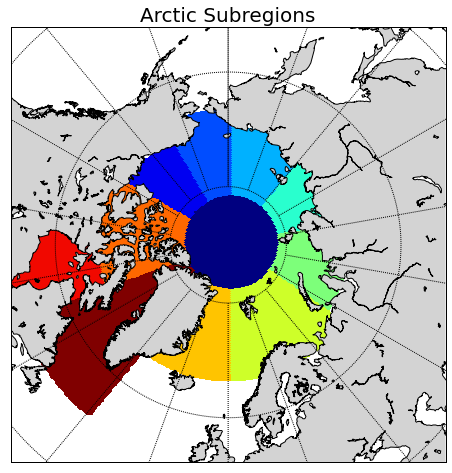

In [578]:
def draw_region(lat, lon, subregion):
    fig = plt.figure(figsize = (10, 8))
    m = Basemap(projection='nplaea',boundinglat=52,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='lightgray',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    # draw tissot's indicatrix to show distortion.

    xgrid, ygrid = m(lon, lat)
    plt.scatter(xgrid, ygrid, c = subregion, cmap='jet', marker = "s", vmin=0, vmax=10)
    
#     clb = fig.colorbar(sc, shrink=0.80, pad = 0.02)
#     clb.set_label('Sea ice conc. (%)', rotation = 270, fontsize = 15, va = 'bottom')
#     clb.ax.tick_params(labelsize=15)
    plt.title("Arctic Subregions", fontsize = 20)
    plt.savefig('F:\\2021_SIE\\map\\arctic_subregion.png', bbox_inches = "tight")


draw_region(lat, lon, subregion)

In [691]:
df_sie

date  year  month       SIE       AO      BS       CS      ESS  \
0    2012-08-01  2012      8   3784375  2188125  317500   257500   383750   
1    2012-08-02  2012      8   3817500  2180625  332500   230625   438125   
2    2012-08-03  2012      8   3608750  2193125  261250   205625   338125   
3    2012-08-04  2012      8   3522500  2157500  224375   294375   263125   
4    2012-08-05  2012      8   3431875  2135000  330000   114375   271250   
...         ...   ...    ...       ...      ...     ...      ...      ...   
3170 2021-04-20  2021      4  12286875  2278125  988750  1188125  1223125   
3171 2021-04-21  2021      4  12231875  2276875  988125  1186250  1216250   
3172 2021-04-22  2021      4  12208125  2278125  988750  1186250  1211250   
3173 2021-04-23  2021      4  12135000  2277500  988750  1188125  1217500   
3174 2021-04-24  2021      4  12127500  2278125  988750  1188125  1220000   

          LS      KS     BNS      GS       CA       HB      BB  
0     150625    7500   54375   95625   303125    21875       0  
1     155625   14375   41875  120625   285000    16875    1250  
2     162500   19375   35000  113125   262500    16250       0  
3     165625   18125   45000   88125   243125    18750    1875  
4     164375   16875   46875  116875   220000    14375    1875  
...      ...     ...     ...     ...      ...      ...     ...  
3170  796875  910625  313125  416875  1131875  1062500  860625  
3171  792500  892500  299375  429375  1131250  1063750  856875  
3172  790000  878125  317500  431875  1128125  1081250  838125  
3173  778750  867500  335625  436250  1129375  1068125  811875  
3174  780000  878750  370000  436250  1130625  1058750  789375  

[3175 rows x 15 columns]

## (1) Temporal analysis

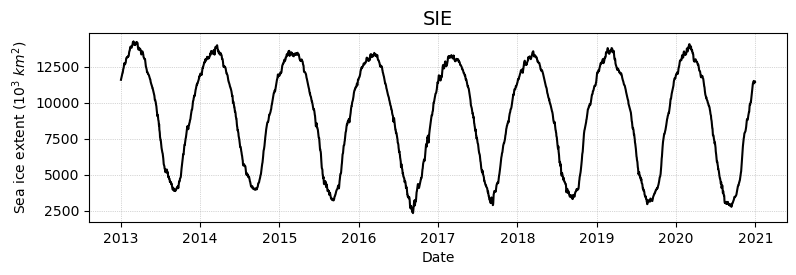

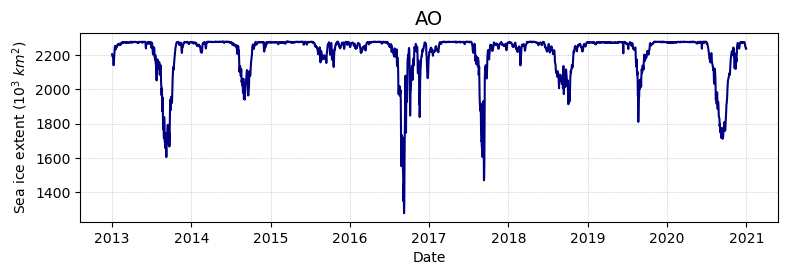

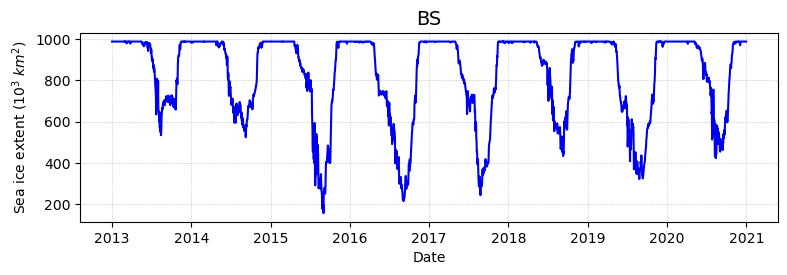

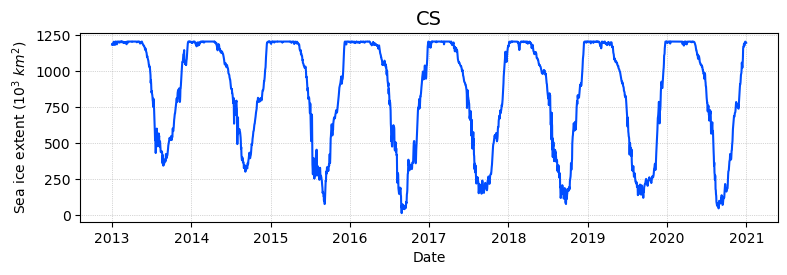

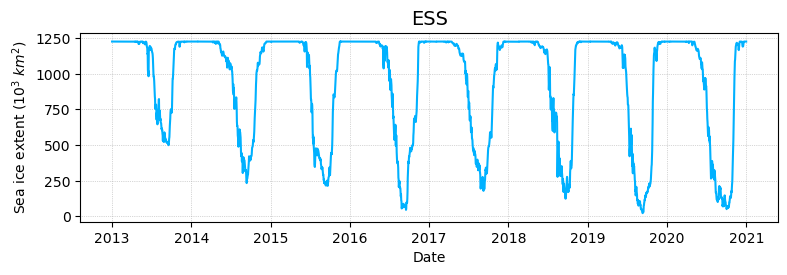

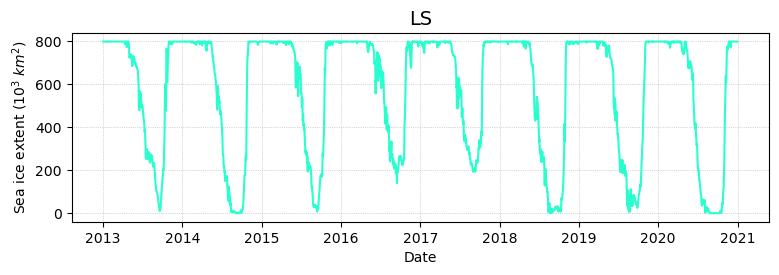

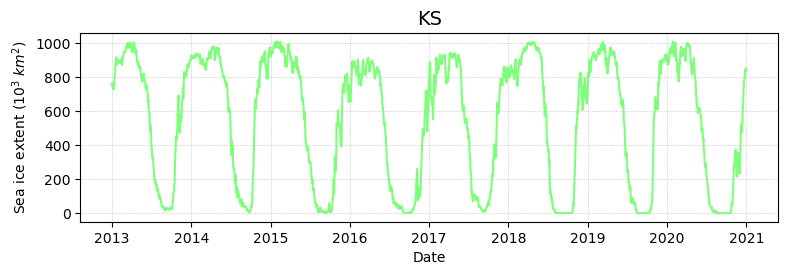

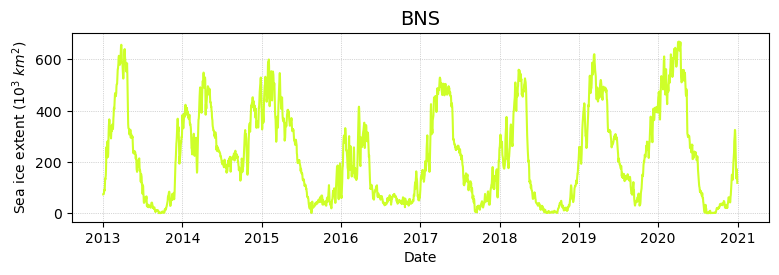

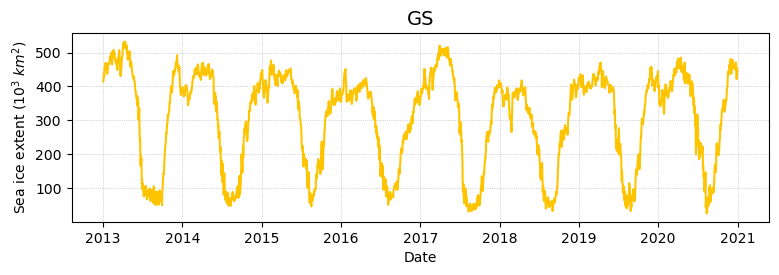

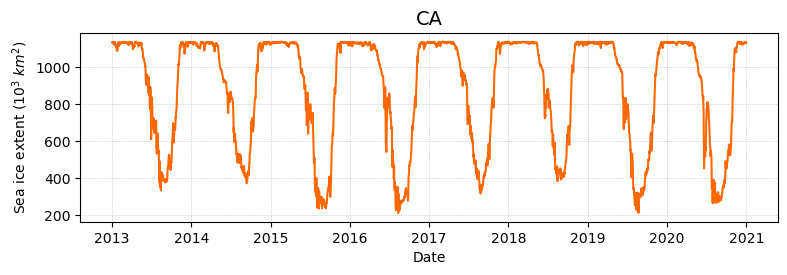

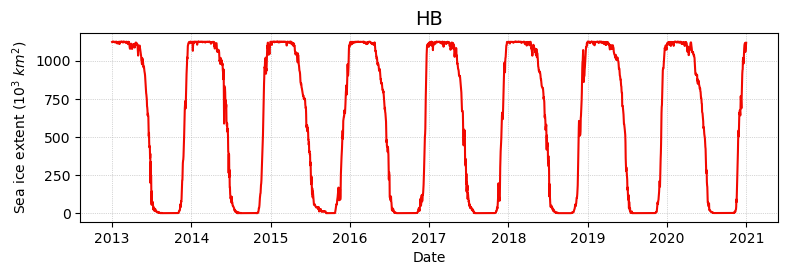

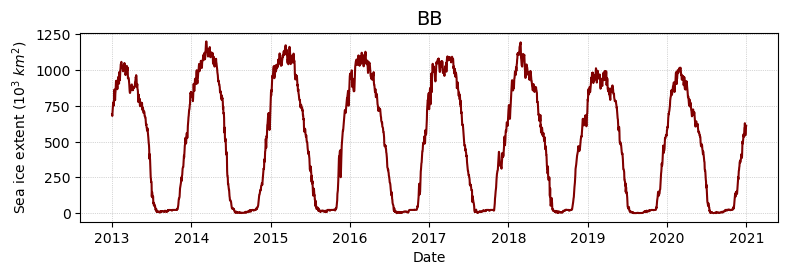

In [1044]:
df_sie = pd.read_csv("F:\\2021_SIE\\result\\SIE_NH.csv", index_col = 0)
df_sie['date'] = pd.to_datetime(df_sie['date'])
df_sie = df_sie.loc[(df_sie['date'] < dt.datetime(2021, 1, 1)) &
                    (df_sie['date'] >= dt.datetime(2013, 1, 1)), :].reset_index(drop = True)

code = 0
for field in df_sie.keys()[3:]:
    plt.figure(figsize = (9,2.5), dpi=100)
    
    if code == 0:
        rgba = "k"
    else:
        cmap = cm.get_cmap('jet')
        rgba = cmap((code-1)/len(df_sie.keys()[5:]))
    
    plt.plot(df_sie['date'], df_sie[field]/1000, color = rgba)
    plt.xlabel("Date")
    plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
    plt.grid(ls = ":", lw = 0.5)
    plt.title(field, fontsize = 14)
    
    plt.savefig("F:\\2021_SIE\\result\\1_temporal\\Daily_SIE_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

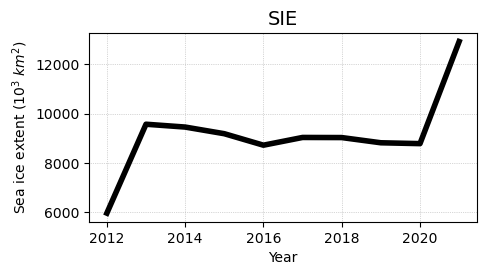

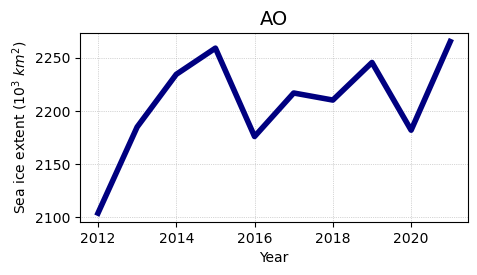

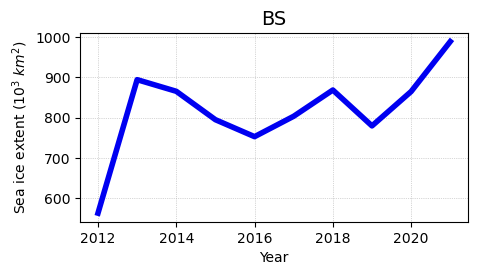

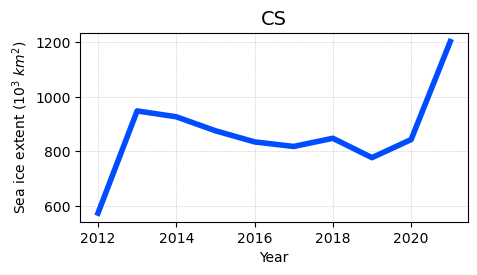

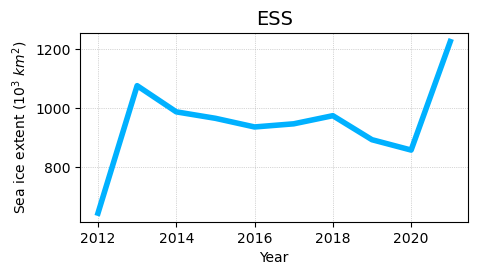

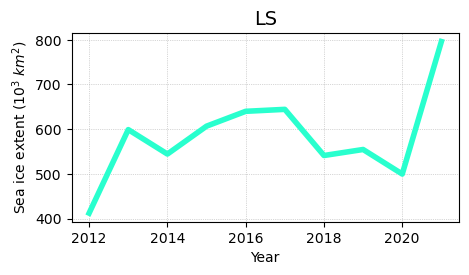

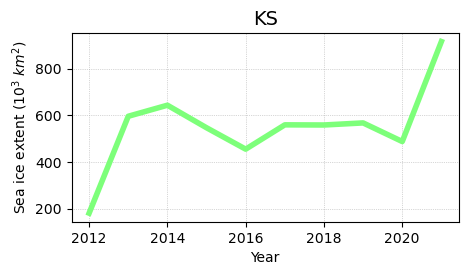

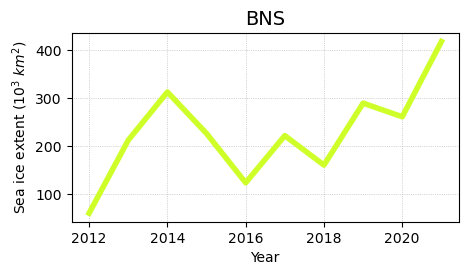

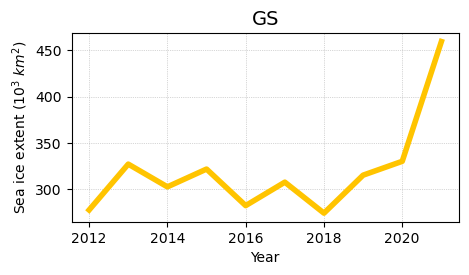

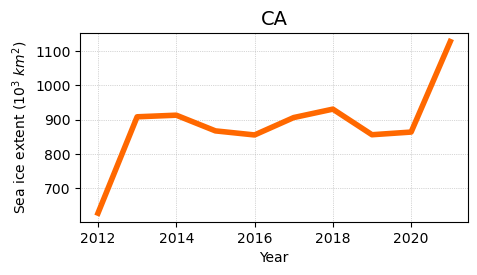

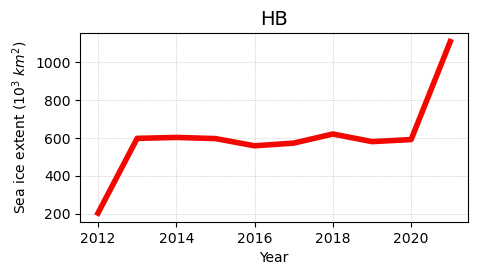

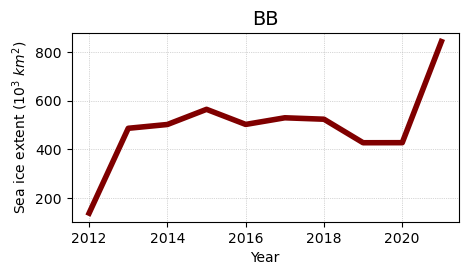

In [1043]:
df_year = df_sie.groupby(['year'], as_index=False).mean()
df_year_sd = df_sie.groupby(['year'], as_index=False).std()*0

code = 0
for field in df_year.keys()[2:]:
    plt.figure(figsize = (5,2.5), dpi=100)
    
    if code == 0:
        rgba = "k"
    else:
        cmap = cm.get_cmap('jet')
        rgba = cmap((code-1)/len(df_sie.keys()[5:]))
    
    plt.plot(df_year['year'], df_year[field]/1000, color = rgba, lw = 4)
    plt.fill_between(df_year['year'], df_year[field]/1000 - df_year_sd[field]/1000,
                     df_year[field]/1000 + df_year_sd[field]/1000,
                     alpha = 0.3, linewidth = 0, color = rgba)
    plt.xlabel("Year")
    plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
    plt.grid(ls = ":", lw = 0.5)
    plt.title(field, fontsize = 14)
    
    plt.savefig("F:\\2021_SIE\\result\\1_temporal\\yearly_SIE_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

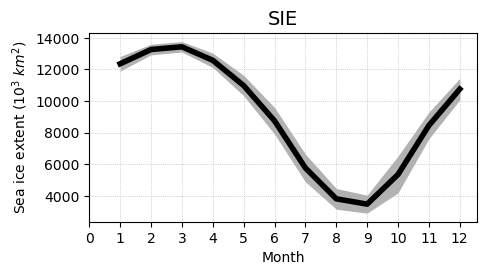

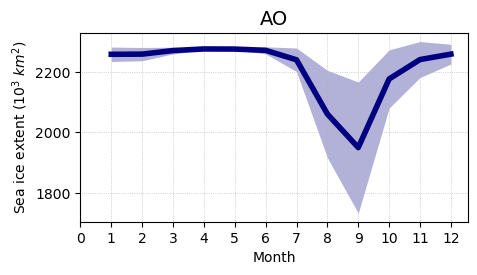

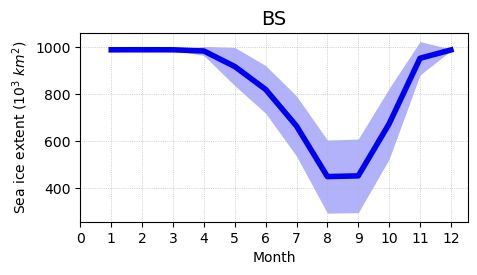

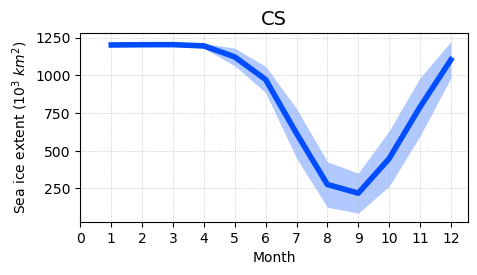

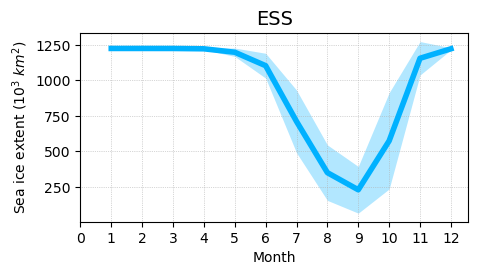

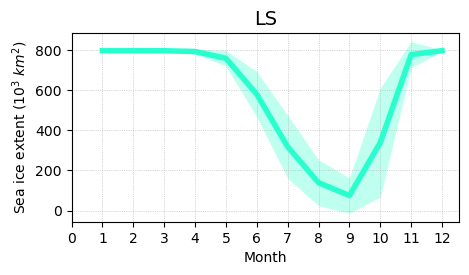

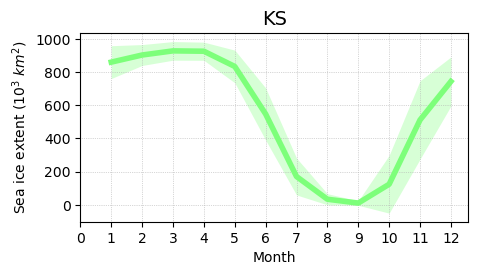

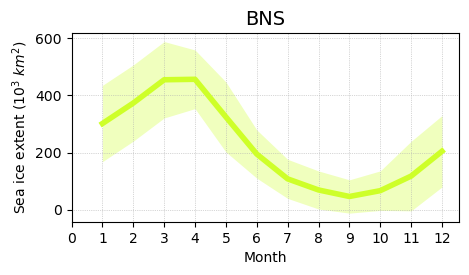

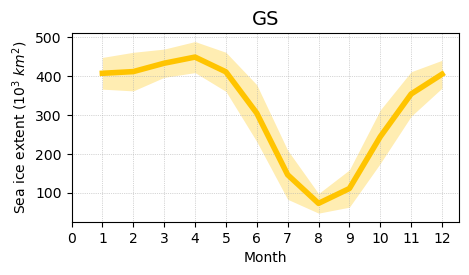

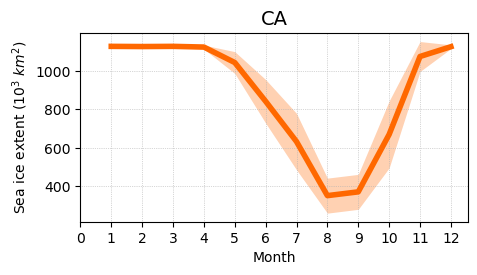

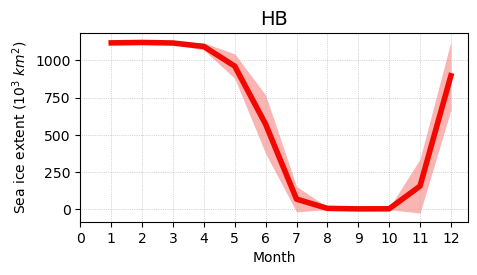

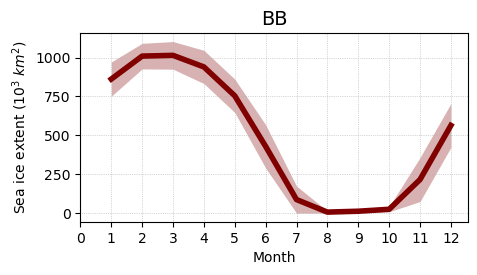

In [1042]:
df_month = df_sie.groupby(['month'], as_index=False).mean()
df_month_sd = df_sie.groupby(['month'], as_index=False).std()

code = 0
months = np.arange(0, 13)
for field in df_year.keys()[2:]:
    plt.figure(figsize = (5,2.5), dpi=100)
    
    if code == 0:
        rgba = "k"
    else:
        cmap = cm.get_cmap('jet')
        rgba = cmap((code-1)/len(df_sie.keys()[5:]))
    
    plt.plot(df_month['month'], df_month[field]/1000, color = rgba, lw = 4)
    plt.fill_between(df_month['month'], df_month[field]/1000 - df_month_sd[field]/1000,
                     df_month[field]/1000 + df_month_sd[field]/1000,
                     alpha = 0.3, linewidth = 0, color = rgba)
    plt.xlabel("Month")
    plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
    plt.grid(ls = ":", lw = 0.5)
    plt.title(field, fontsize = 14)
    plt.xticks(months)
    
    plt.savefig("F:\\2021_SIE\\result\\1_temporal\\monthly_SIE_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

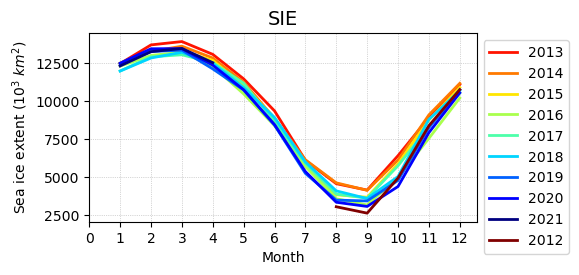

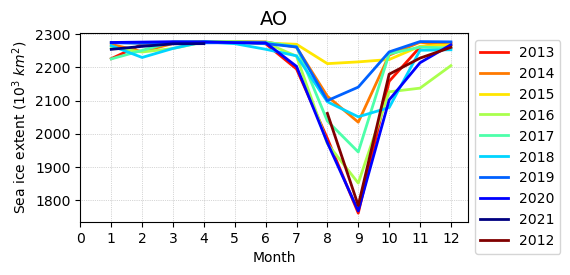

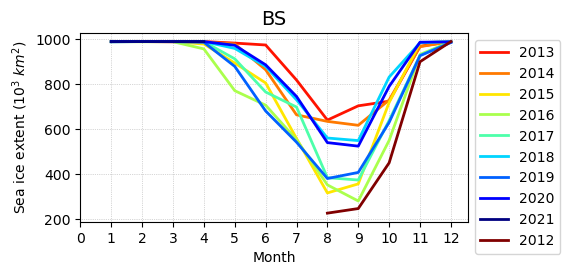

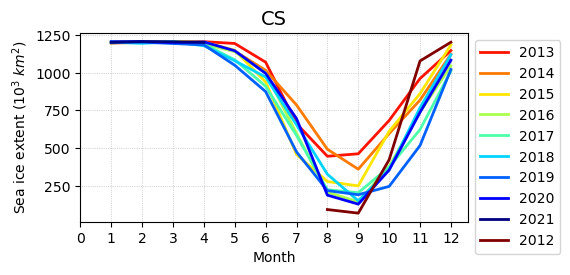

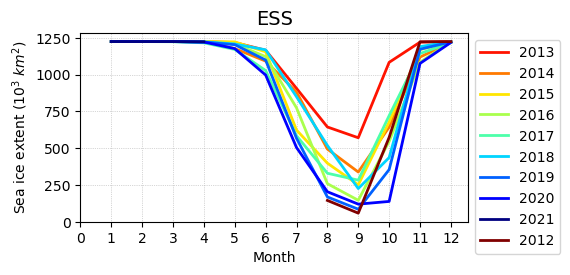

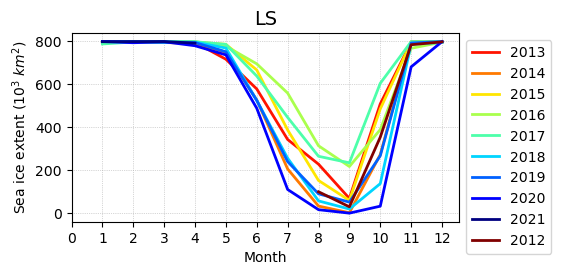

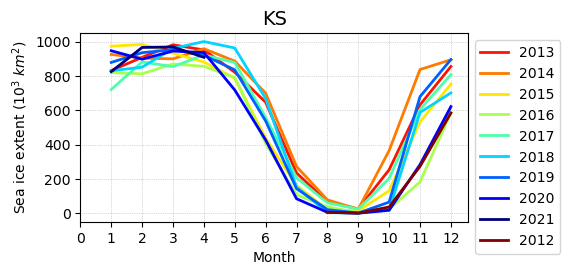

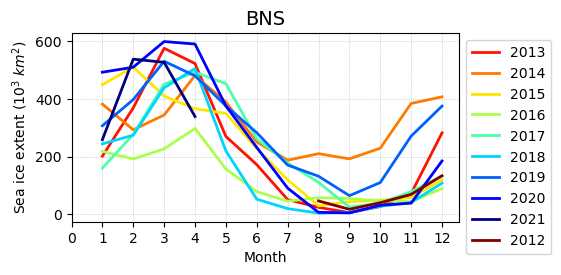

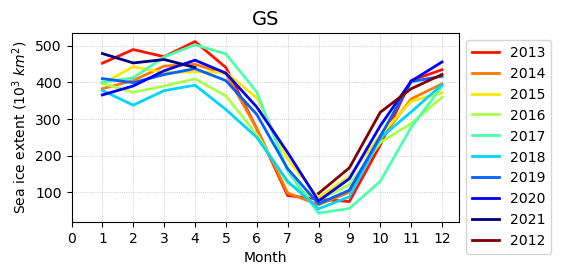

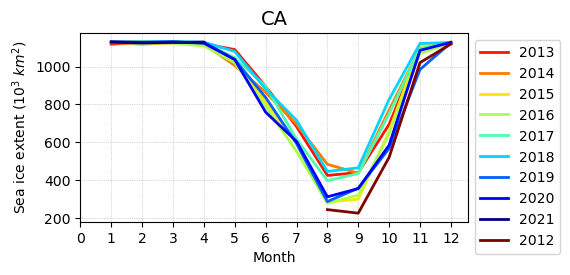

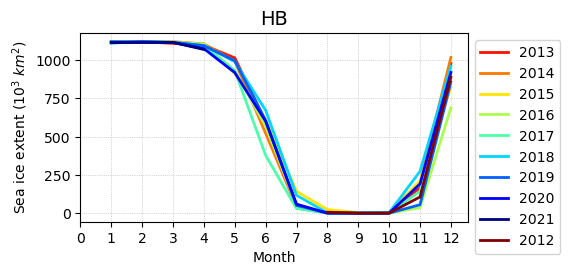

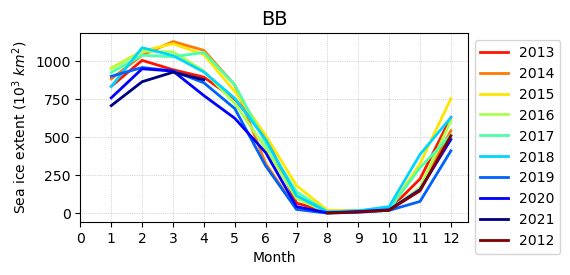

In [1041]:
df_month = df_sie.groupby(['month', 'year'], as_index=False).mean()
df_month_sd = df_sie.groupby(['month', 'year'], as_index=False).std()

code = 0
months = np.arange(0, 13)
for field in df_month.keys()[2:]:
    
    plt.figure(figsize = (5,2.5), dpi=100)
    years = pd.unique(df_month['year'])
    
    for y in years:

        cmap = cm.get_cmap('jet')
        rgba = cmap((years.max()-y)/(years.max()-years.min()))
        
        data = df_month.loc[df_month['year'] == y, :]
        plt.plot(data['month'], data[field]/1000, lw = 2, label=y, color = rgba)
#         plt.fill_between(data['month'], data[field]/1000 - data[field]/1000,
#                          data[field]/1000 + data[field]/1000,
#                          alpha = 0.3, linewidth = 0, color = rgba)
        plt.xlabel("Month")
        plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
        plt.grid(ls = ":", lw = 0.5)
        plt.title(field, fontsize = 14)
        plt.xticks(months)
        
    plt.legend(bbox_to_anchor=(1.0, 1))
    plt.savefig("F:\\2021_SIE\\result\\1_temporal\\monthly_SIE_by_year_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

In [736]:
years = pd.unique(df_month['year'])
years.max()

2020

### * Fourier Transform

In [1039]:
from numpy.fft import fft, ifft

In [ ]:
for field in df_sie.keys()[3:]:
    dti = pd.date_range(start = "03/10/2016", end = "03/03/2021", freq = "H")
    df0 = dti[dti.year == year].to_frame(index = True, name = "local")
    
for i in range(0, len(parameters)):
    parameter = parameters[i]
    df_sample = df_inter.dropna(subset=[parameter])
    X=fft(df_sample[parameter])
    N=len(X)
    n = np.arange(N)
    
    # original data - about hourly sampling -> sr=24: frequency 1 means 24 hours (one day)
    sr = 24 # sampling ratio
    T= N/sr
    freq=n/T
    
    ax[i].stem(freq, np.abs(X), markerfmt=" ", basefmt=colors[i], linefmt = colors[i], label = parameter)
    ax[i].set_ylabel('FFT Amp.')
    ax[i].legend()
    # set y-axis limit
    ax[i].set_ylim(0, np.abs(X).max()/4)
    ax[i].grid(linestyle = ":", linewidth = 1)

plt.xlim(-0.1, 7)    
plt.xlabel('Freq (1/day)')
plt.savefig("Figures/FFT_freq.png", bbox_inches = "tight")

## (3) Dendrogram

In [467]:
from scipy.cluster import hierarchy
from turbustat.statistics import Dendrogram_Stats
from astrodendro import Dendrogram

In [1021]:
df_sie = pd.read_csv("F:\\2021_SIE\\result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    for m in sorted(df_sie['month'].unique()[:]):
        t0_str = str(y) + str(m).zfill(2)
        
        min_sic = 80
        fig, ax =  plt.subplots(1, 2, figsize = (12, 6), dpi = 100)
        idx = (df_sie['year'] == y) & (df_sie['month'] == m)
        sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
        d = Dendrogram.compute(sic_mean, min_value=min_sic, min_delta=1, min_npix=40, verbose=False) 
        p = d.plotter()
        
        # Draw dendrogram
        p.plot_tree(ax[0], color='black')
        p.get_lines()
        
        ax[0].set_title("Dendrogram_{0}".format(t0_str))
        
        img = ax[1].imshow(sic_mean, cmap="gray", vmin = 0, vmax=100)
        clb = fig.colorbar(img, ax = ax[1], shrink = 0.7, pad = 0.02)
        clb.set_label('Sea ice conc. (%)', rotation = 270, fontsize = 12, va = 'bottom')
        
        cmap = cm.get_cmap('jet')
        
        k = 0; num = len(d.leaves)
        
        max_level = 0
        for trk in d.trunk:
            if len(trk.descendants) > 0:
                for des in trk.descendants:
                    if des.level >= max_level:
                        max_level = des.level
            if trk.level >= max_level:
                max_level = trk.level
        
        for trk in d.trunk:
            if len(trk.descendants) > 0:
                for des in trk.descendants:
                    rgba = cmap((des.vmin-min_sic)/(100-min_sic))
                    p.plot_contour(ax[1], structure=des.idx, lw=0.5, colors=np.array(rgba).reshape(-1,4))
                    ax[0].axhline(des.vmin, color = rgba, alpha = 0.3, label = des.level)
            rgba = cmap((trk.vmin-min_sic)/(100-min_sic))
            p.plot_contour(ax[1], structure=trk.idx, lw=0.5, colors=np.array(rgba).reshape(-1,4))
            ax[0].axhline(trk.vmin, color = rgba, alpha = 0.3, label = trk.level)

        
#         for leaf in d.trunk:
#             leaf.descendants
#             rgba = cmap((leaf.vmin-60)/(100-60))
#             p.plot_contour(ax[1], structure=k, lw=1, colors=np.array(rgba).reshape(-1,4))
#             k += 1
        
        ax[1].set_title("Contour_{0}".format(t0_str))
#         print(max_level)
        
        plt.savefig("F:\\2021_SIE\\result\\2_dendrogram\\dendro_{0}.png".format(t0_str), bbox_inches = "tight")
        plt.close()
        
    print(y)

2013
2014
2015
2016
2017
2018
2019
2020


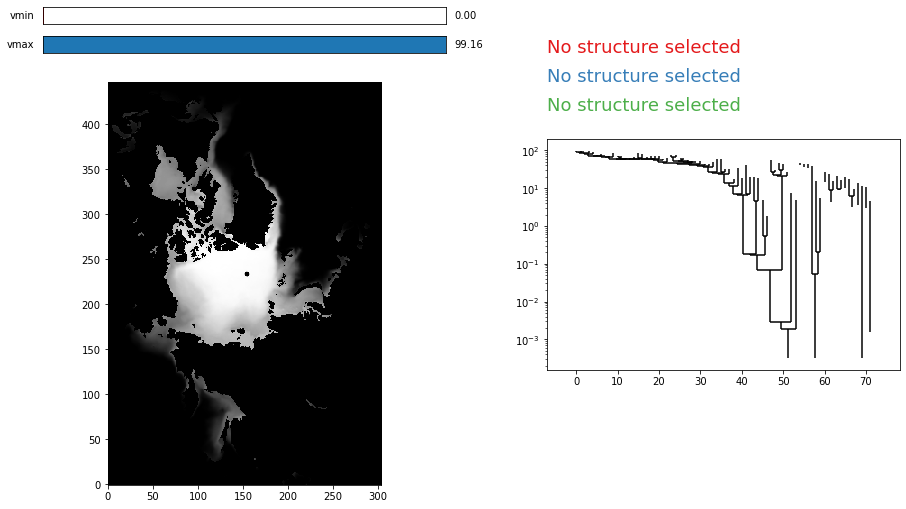

In [841]:
sic_mean = np.mean(sic_con, axis = 2)
d = Dendrogram.compute(sic_mean, min_value=0, min_delta=1, min_npix=20, verbose=False) 
# ax = plt.subplot(111)  
v = d.viewer()
v.show()

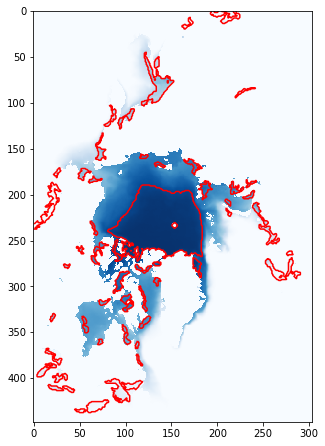

In [842]:
p = d.plotter()

fig = plt.figure(figsize = (5,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(sic_mean, interpolation='nearest', cmap=plt.cm.Blues, vmax=100)


for leaf in d.leaves:

    p.plot_contour(ax, structure=leaf, lw=2, colors='red')

#     s = PPStatistic(leaf)
#     ellipse = s.to_mpl_ellipse(edgecolor='orange', facecolor='none')

#     ax.add_patch(ellipse)

# # Show contour for ``min_value``
# p.plot_contour(ax, color='black')

# # Highlight two branches
# p.plot_contour(ax, structure=100, lw=3, colors='red')
# p.plot_contour(ax, structure=110, lw=3, colors='orange')

## (4) Get statistical moments (skewness & kurtosis)

In [ ]:
3# Get statistical moments (skewness & kurtosis) -----------------

def get_statistics(z, r = 5):
    h,w = np.shape(z)
    z_mean = np.zeros((h, w))
    z_var = np.zeros((h, w))
    z_skew = np.zeros((h, w))
    z_kurt = np.zeros((h, w))
    
    for i in range(0, h):
        for j in range(0, w):
            z_mean[i,j] = np.mean(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)])
            z_var[i,j] = np.var(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)])
            z_skew[i,j] = skew(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)].flatten())
            z_kurt[i,j] = kurtosis(z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)].flatten())
    
    return z_mean, z_var, z_skew, z_kurt

In [1051]:
df_sie = pd.read_csv("F:\\2021_SIE\\result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    idx = (df_sie['year'] == y)
    sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
    
    sic_mean[sic_mean == 0] = np.nan
    t0_str = str(y)
    
    r = 3
    z_mean, z_var, z_skew, z_kurt = get_statistics(sic_mean, r)
    
    fig, ax = plt.subplots(2,2,figsize = (10, 10), dpi = 100)
    ax_mean = ax[0][0]
    ax_var = ax[0][1]
    ax_skew = ax[1][0]
    ax_kurt = ax[1][1]

    img_mean = ax_mean.imshow(z_mean, cmap = 'Blues_r', vmin = 0, vmax = 100)
    fig.colorbar(img_mean, ax = ax_mean, shrink = 0.8, pad = 0.05)
    ax_mean.set_title("Mean ({0})".format(t0_str))

    img_var = ax_var.imshow(z_var, vmin = 0, vmax = 20)
    fig.colorbar(img_var, ax = ax_var, shrink = 0.8, pad = 0.05)
    ax_var.set_title("Var ({0})".format(t0_str))

    img_skew = ax_skew.imshow(z_skew, cmap = "RdBu_r", vmin = -2, vmax = 2)
    fig.colorbar(img_skew, ax = ax_skew, shrink = 0.8, pad = 0.05)
    ax_skew.set_title("Skewness ({0})".format(t0_str))

    img_kurt = ax_kurt.imshow(z_kurt, cmap = "BrBG", vmin = -2, vmax = 2)
    fig.colorbar(img_kurt, ax = ax_kurt, shrink = 0.8, pad = 0.05)
    ax_kurt.set_title("Kurtosis ({0})".format(t0_str))
    
    plt.savefig("F:\\2021_SIE\\result\\3_stat_moments\\stat_moments_r{0}_{1}.png".format(r, t0_str),
                bbox_inches = "tight")
    plt.close()
    
    print(t0_str)

2013
2014
2015
2016
2017
2018
2019
2020


In [1048]:
np.shape(sic_con)

(448, 304, 3175)

In [ ]:
for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    for m in sorted(df_sie['month'].unique()[:]):
        idx = (df_sie['year'] == y) & (df_sie['month'] == m)
        sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
        sic_mean[sic_mean == 0] = np.nan
        t0_str = str(y) + str(m).zfill(2)
        
        r = 3
        z_mean, z_var, z_skew, z_kurt = get_statistics(sic_mean, r)

        fig, ax = plt.subplots(2,2,figsize = (10, 10), dpi = 100)
        ax_mean = ax[0][0]
        ax_var = ax[0][1]
        ax_skew = ax[1][0]
        ax_kurt = ax[1][1]

        img_mean = ax_mean.imshow(z_mean, cmap = 'Blues_r', vmin = 0, vmax = 100)
        fig.colorbar(img_mean, ax = ax_mean, shrink = 0.8, pad = 0.05)
        ax_mean.set_title("Mean ({0})".format(t0_str))

        img_var = ax_var.imshow(z_var, vmin = 0, vmax = 20)
        fig.colorbar(img_var, ax = ax_var, shrink = 0.8, pad = 0.05)
        ax_var.set_title("Var ({0})".format(t0_str))

        img_skew = ax_skew.imshow(z_skew, cmap = "RdBu_r", vmin = -2, vmax = 2)
        fig.colorbar(img_skew, ax = ax_skew, shrink = 0.8, pad = 0.05)
        ax_skew.set_title("Skewness ({0})".format(t0_str))

        img_kurt = ax_kurt.imshow(z_kurt, cmap = "BrBG", vmin = -2, vmax = 2)
        fig.colorbar(img_kurt, ax = ax_kurt, shrink = 0.8, pad = 0.05)
        ax_kurt.set_title("Kurtosis ({0})".format(t0_str))

        plt.savefig("F:\\2021_SIE\\result\\3_stat_moments\\stat_moments_r{0}_{1}.png".format(r, t0_str),
                    bbox_inches = "tight")
        
        plt.close()
        print(t0_str)

201301


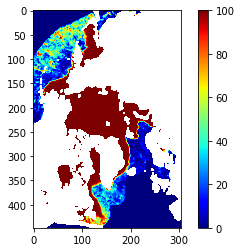

In [389]:
sic_max = np.max(sic_con, axis = 2)
plt.imshow(sic_max, cmap = "jet", vmax = 100)
plt.colorbar()

## (5) PCA

In [535]:
from sklearn.decomposition import PCA

In [837]:
## Prepare functions for PCA analysis
def reshape_pca(sic_con):
    h, w, s = np.shape(sic_con)
    pca_in = np.zeros((h*w, s))
    for i in range(0, h):
        for j in range(0, w):
            pca_in[i + j*h, :] = sic_con[i, j, :]
    return pca_in

def decomposition_pca(p, n, lat):
    # p: pca components
    # n: number of PCA components
    h, w = np.shape(lat)
    out = np.zeros((h, w, n))
    
    for i in range(0, h):
        for j in range(0, w):
            out[i, j, :] = p[i + j*h, :n]
            
    return out

def draw_pca(pca_c, imgname):
    fig, ax = plt.subplots(2,3,figsize = (14, 10), dpi = 80)
    h, w = np.shape(ax)
    
    n = 0
    for i in range(0, h):
        for j in range(0, w):
            plt.subplot2grid((h, w), (i,j))
            plt.imshow(pca_c[:, :, n])  
            plt.colorbar(shrink = 0.8)
            plt.title("PCA_{0}".format(n+1))
            n+=1
            
    plt.savefig(imgname, bbox_inches = "tight")

2013
2014
2015
2016
2017
2018
2019
2020


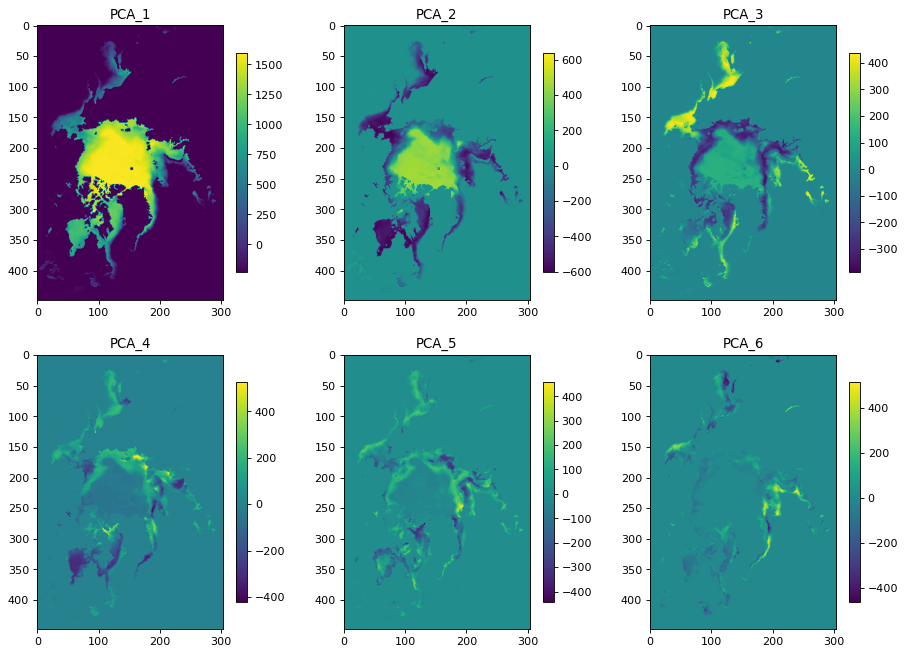

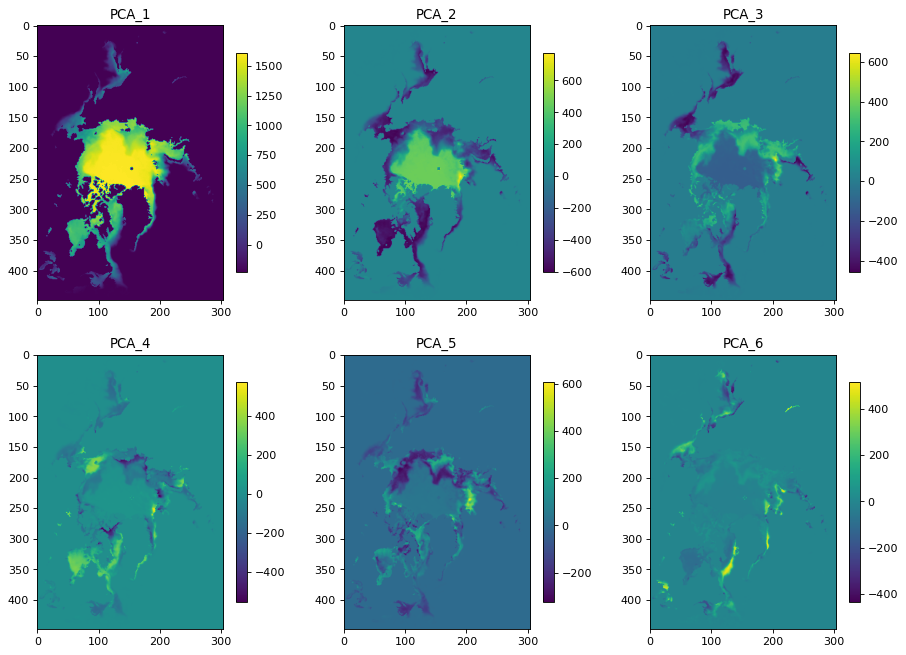

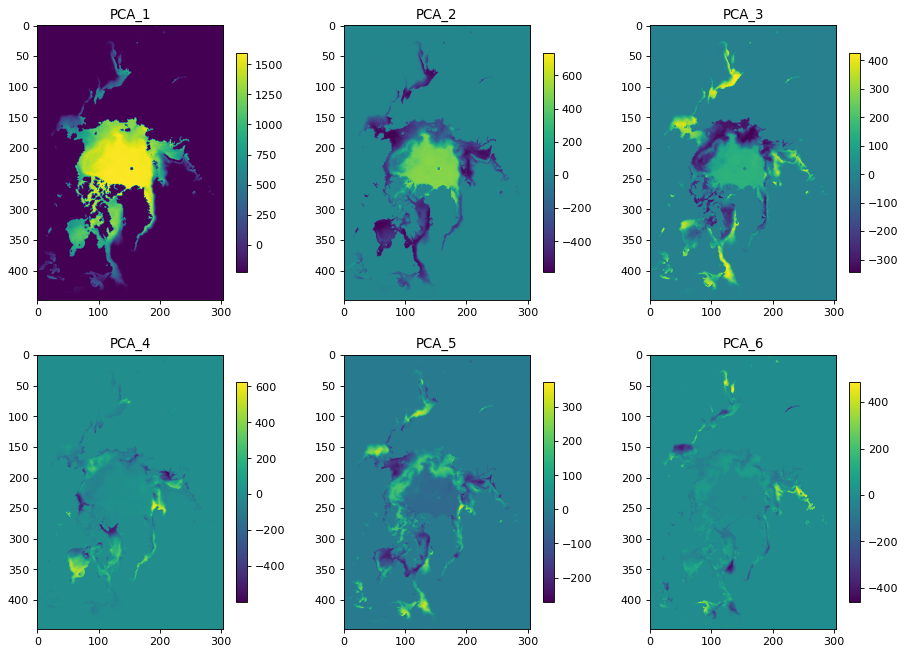

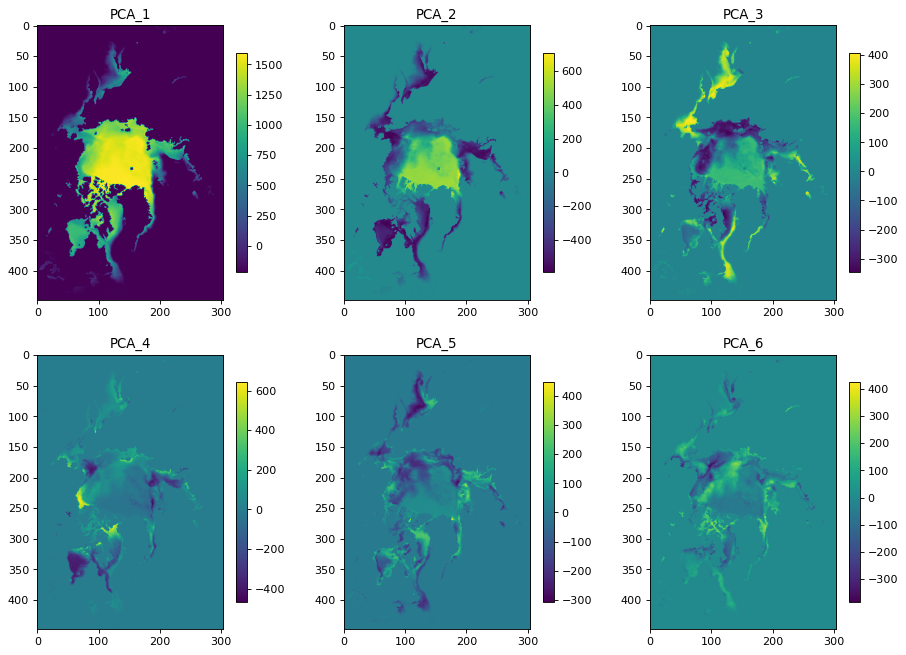

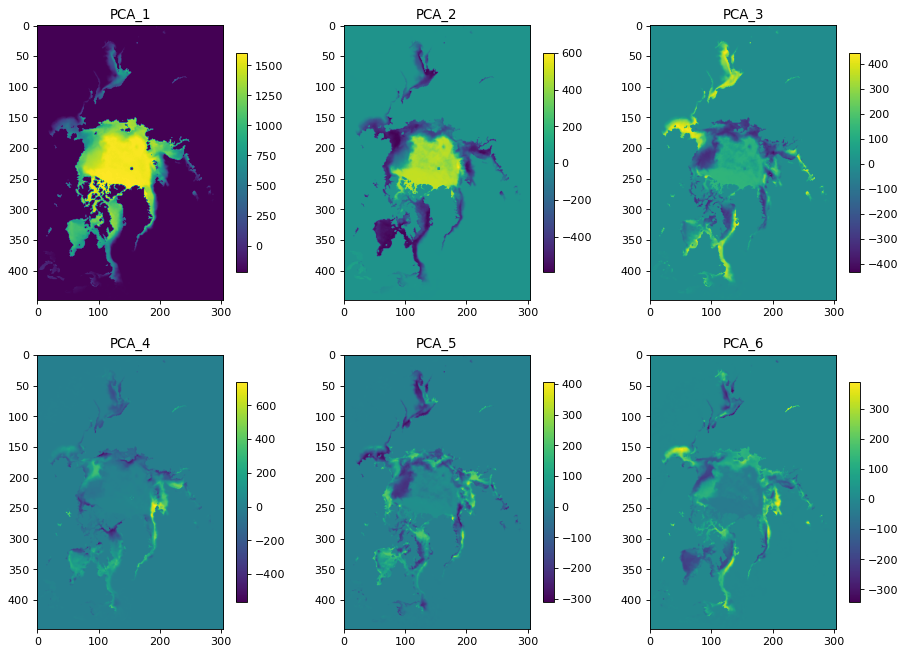

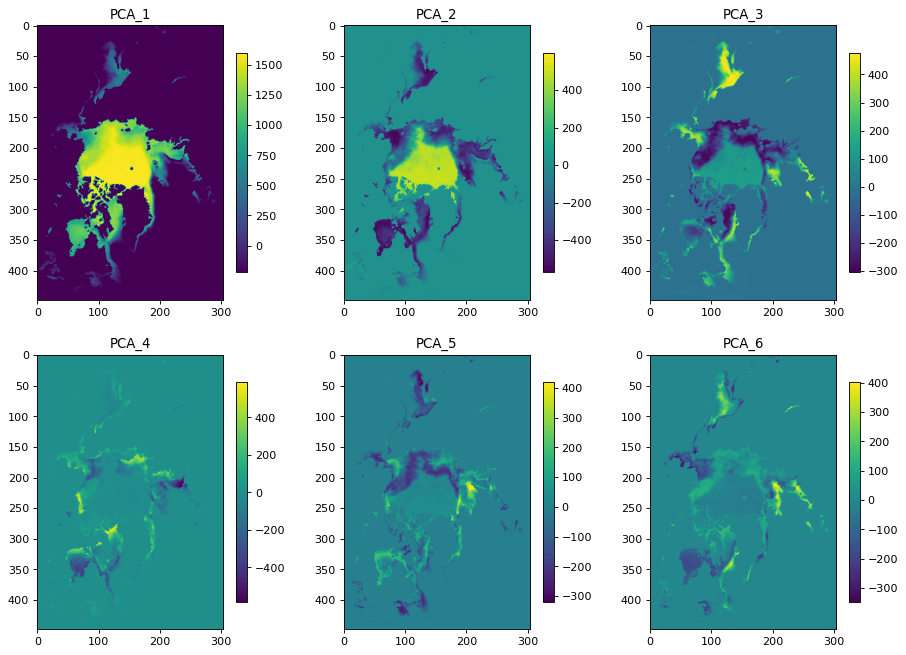

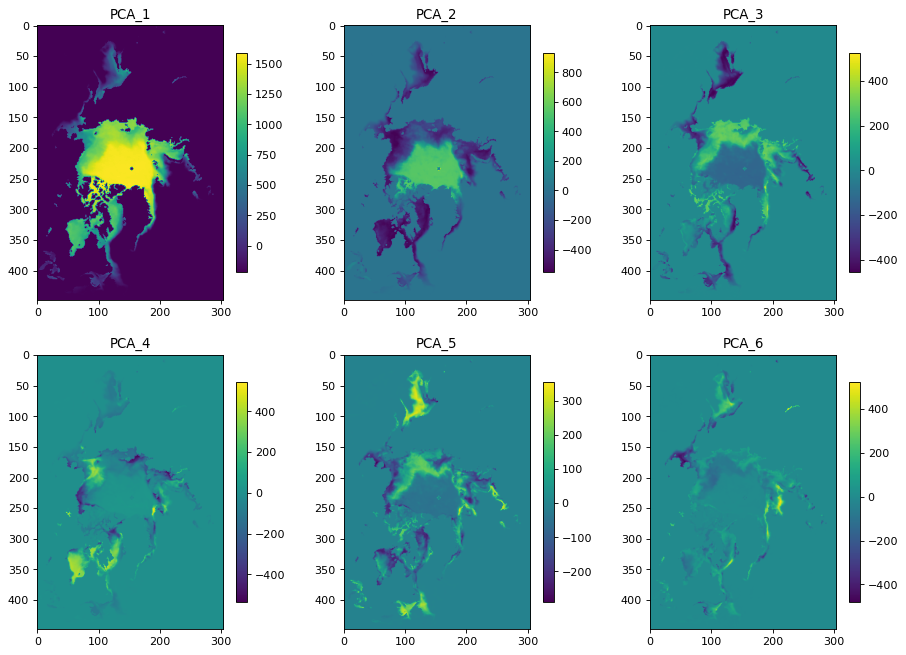

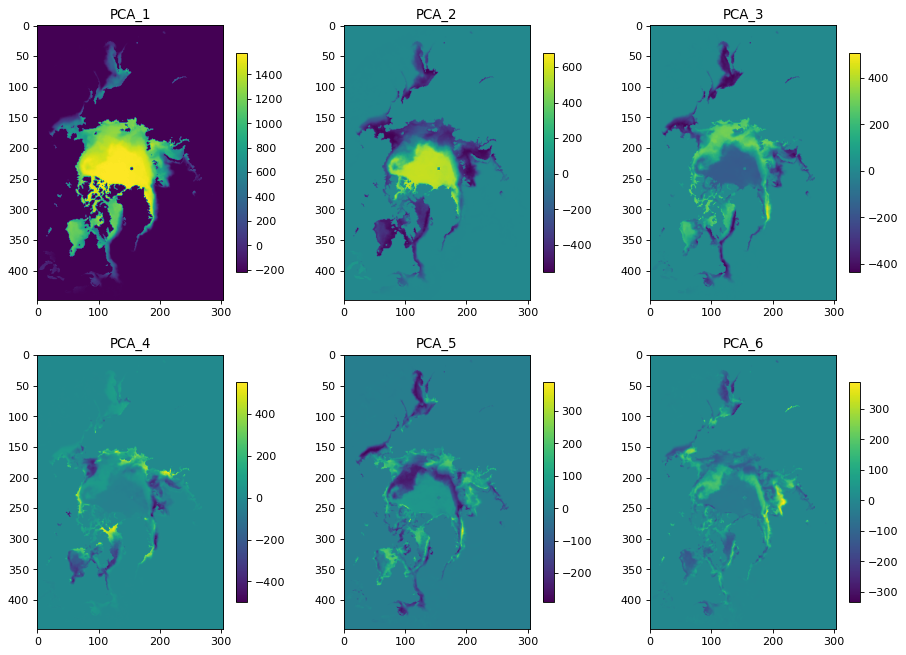

In [838]:
df_sie = pd.read_csv("F:\\2021_SIE\\result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    idx = (df_sie['year'] == y)
    sic_part = sic_con[:, :, idx]
    
    # PCA analysis
    n = 10
    pca_in = reshape_pca(sic_part) # make input for PCA
    pca = PCA(n_components=n)
    pca_c0 = pca.fit_transform(pca_in)
    pca_c = decomposition_pca(pca_c0, n, lat) # PCA tranformation
    del pca_c0, pca_in
    
    imgname = "F:\\2021_SIE\\map\\PCA_{0}.png".format(y)
    draw_pca(pca_c, imgname)
    
    print(y)

In [1040]:
np.shape(sic_con)

(448, 304, 3175)

In [ ]:

n = 6

pca_in = reshape_pca(sic_con)
pca = PCA(n_components=n)
pca_c0 = pca.fit_transform(pca_in)
pca_c = decomposition_pca(pca_c0, n, lat)
del pca_c0, pca_in

In [839]:
gc.collect()

206922